```
Topic:        Project 3
Subject:      Determining Benign or Malignant Breast Cancer
Date:         08/05/2020
Name:         David Weon

Notebook has been cleaned using nbextension 'Code prettify'
```

# Connecting to AWS Postgresql

In [1]:
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np

In [2]:
#connect to aws machine with elastic IP
cnx = create_engine('postgresql://ubuntu@34.196.129.175:5432/breastcancer')

In [3]:
pd.read_sql_query('''SELECT * FROM dataset limit 20''', cnx).head()

,index,id,clumpthickness,uniformcellsize,uniformcellshape,margadhesion,epithelial,barenuclei,blandchromatin,normalnucleoli,mitoses,benormal
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


# Data Import, Clean, Check

## Data Import

In [4]:
#import data from aws postgresql
breastcancer = pd.DataFrame(pd.read_sql_query('''SELECT * FROM dataset''',
                                              cnx))
breastcancer = breastcancer.set_index('index')

## Data Clean

In [5]:
X, y = breastcancer.drop(['id', 'benormal', 'uniformcellshape'],
                         axis=1), breastcancer['benormal']

In [6]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=71)

In [7]:
#check for '?' values in X_trainval set
X_trainval.isin(['?']).any()

clumpthickness     False
uniformcellsize    False
margadhesion       False
epithelial         False
barenuclei          True
blandchromatin     False
normalnucleoli     False
mitoses            False
dtype: bool

In [8]:
#replace '?' with nan for cleaning
X_trainval['barenuclei'].replace('?', np.nan, inplace=True)
X_test['barenuclei'].replace('?', np.nan, inplace=True)

#convert columns to int/float
X_trainval = X_trainval.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)
y_trainval = y_trainval.apply(pd.to_numeric)
y_test = y_test.apply(pd.to_numeric)

#replace '?' with the column mean
X_trainval['barenuclei'].fillna(X_trainval['barenuclei'].mean(), inplace=True)
X_test['barenuclei'].fillna(X_test['barenuclei'].mean(), inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


## Data Check

In [9]:
X_trainval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 131 to 107
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   clumpthickness   559 non-null    int64  
 1   uniformcellsize  559 non-null    int64  
 2   margadhesion     559 non-null    int64  
 3   epithelial       559 non-null    int64  
 4   barenuclei       559 non-null    float64
 5   blandchromatin   559 non-null    int64  
 6   normalnucleoli   559 non-null    int64  
 7   mitoses          559 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 39.3 KB


In [10]:
X_trainval.describe()

,clumpthickness,uniformcellsize,margadhesion,epithelial,barenuclei,blandchromatin,normalnucleoli,mitoses
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,4.488372,3.159213,2.797853,3.202147,3.622263,3.457961,2.860465,1.543828
std,2.804782,3.013955,2.817685,2.167765,3.651191,2.400255,3.022946,1.642118
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,4.000000,4.000000,7.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [11]:
#class distribution
y_trainval.value_counts()

0    361
1    198
Name: benormal, dtype: int64

## Data Visualization

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [13]:
#testing a merge to better visualize correlation and pairplot
test_df = pd.merge(X_trainval.reset_index(),
                   y_trainval.reset_index(),
                   on='index')
test_df = test_df.set_index('index')

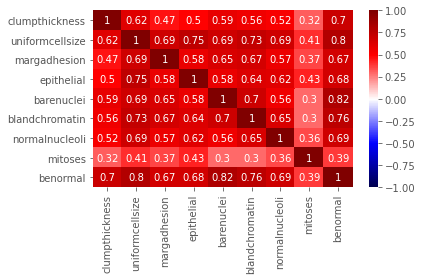

In [14]:
#check for correlation
sns.heatmap(test_df.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)
plt.tight_layout()

plt.savefig('breastcancer_heatmap.png', dpi=600)
#decided to drop uniformcellshape given its high correlation with uniformcellsize

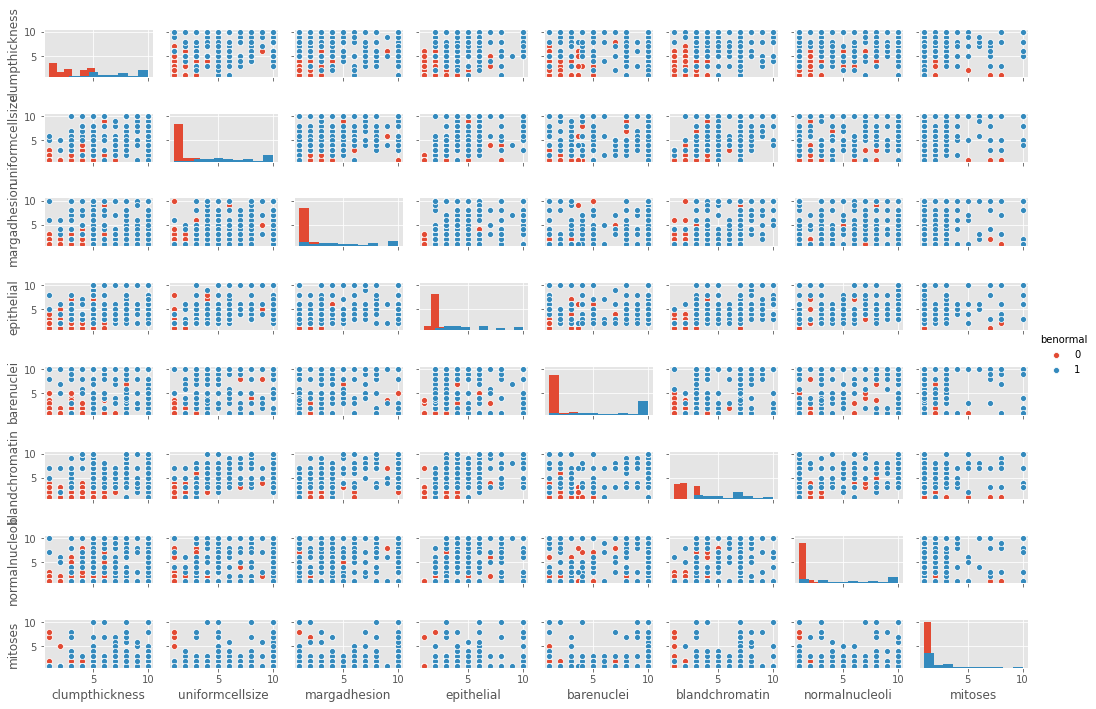

In [15]:
#distribution of features
sns.pairplot(test_df, height=1.2, aspect=1.5, hue='benormal', diag_kind='hist')

# Modeling

## Dummy Model

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

In [17]:
#getting metrics for baseline reference
dummy = DummyClassifier(strategy="stratified", random_state=71)
dummy.fit(X_trainval, y_trainval)
dummy.score(X_test, y_test)

0.5714285714285714

In [18]:
dummy_pred = dummy.predict(X_test)

In [19]:
dummy_accuracy = accuracy_score(y_test, dummy_pred)
dummy_accuracy

0.5714285714285714

In [20]:
dummy_precision = precision_score(y_test,
                                  dummy_pred,
                                  average='binary',
                                  pos_label=1)
dummy_precision

0.3508771929824561

In [21]:
dummy_recall = recall_score(y_test, dummy_pred, average='binary', pos_label=1)
dummy_recall

0.46511627906976744

In [22]:
dummy_f1 = f1_score(y_test, dummy_pred, average='binary', pos_label=1)
dummy_f1

0.4

In [23]:
dummy_rocauc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])
dummy_rocauc

0.5418364900503476

## Cross Validation Metrics for Various Models

In [24]:
import sys
sys.path.append("..")

from src.models.cv_models_train import crossval_knn_scores, crossval_logit_scores, crossval_rfc_scores, crossval_dtc_scores, crossval_svm_scores, crossval_gnb_scores

In [25]:
#logistic regression model
logit_scores = crossval_logit_scores(X_trainval, y_trainval)
logit_scores

[{'accuracy': 0.9624678249678249},
 {'precision': 0.9510488228074877},
 {'recall': 0.9446153846153846},
 {'f1': 0.9472558655103626},
 {'ROC/AUC': 0.992122141240292}]

In [26]:
#decision tree model
dtc_scores = crossval_dtc_scores(X_trainval, y_trainval)
dtc_scores

[{'accuracy': 0.941023166023166},
 {'precision': 0.930115418120314},
 {'recall': 0.9038461538461539},
 {'f1': 0.9160965836055054},
 {'ROC/AUC': 0.9325737618545837}]

In [27]:
#random forest model
rfc_scores = crossval_rfc_scores(X_trainval, y_trainval)
rfc_scores

[{'accuracy': 0.9606981981981981},
 {'precision': 0.9386545910230121},
 {'recall': 0.9547435897435899},
 {'f1': 0.9457665221447179},
 {'ROC/AUC': 0.9899638386410645}]

In [28]:
#k nearest neighbors model
knn_scores = crossval_knn_scores(X_trainval, y_trainval)
knn_scores

[{'accuracy': 0.9588963963963965},
 {'precision': 0.9391324465008676},
 {'recall': 0.9497435897435897},
 {'f1': 0.9430875857323266},
 {'ROC/AUC': 0.9802951571829996}]

In [29]:
#gaussian naive bayes
gnb_scores = crossval_gnb_scores(X_trainval, y_trainval)
gnb_scores

[{'accuracy': 0.9553249678249678},
 {'precision': 0.9078603312394528},
 {'recall': 0.975},
 {'f1': 0.9396791598083711},
 {'ROC/AUC': 0.981070046930492}]

In [30]:
#support vector machine model
svm_scores = crossval_svm_scores(X_trainval, y_trainval)
svm_scores

[{'accuracy': 0.9570945945945946},
 {'precision': 0.9243956043956043},
 {'recall': 0.959871794871795},
 {'f1': 0.9410122171746129},
 {'ROC/AUC': 0.9867691136869219}]

# Model Tuning

In [31]:
from src.models.cv_models_tune_train import crossval_rfc_weight_scores, crossval_logit_weight_scores

## Adjusting Class Weights

### Logistic Regression Model

In [32]:
logit_weight_scores = crossval_logit_weight_scores(X_trainval, y_trainval)
logit_weight_scores

[{'accuracy': 0.9570785070785071},
 {'precision': 0.9288529300157208},
 {'recall': 0.9547435897435899},
 {'f1': 0.940818776566832},
 {'ROC/AUC': 0.9923330601412795}]

### Random Forest Model

In [33]:
rfc_weight_scores = crossval_rfc_weight_scores(X_trainval, y_trainval)
rfc_weight_scores

[{'accuracy': 0.9552927927927929},
 {'precision': 0.9288096431119687},
 {'recall': 0.9496153846153847},
 {'f1': 0.9380216369975406},
 {'ROC/AUC': 0.9879375341490068}]

## Hyperparameter Tuning

### Logistic Regression Model

In [34]:
import time
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import LogisticRegression

param_space = {
    'C': (1,100),
    'solver': ("newton-cg", "lbfgs", "liblinear"),
    'max_iter': (1,200)
}

tune_search = TuneSearchCV(LogisticRegression(),
   param_distributions = param_space,
   n_iter = 2,
   early_stopping = False,
   max_iters = 100,
   search_optimization="bayesian"
)

start = time.time()
tune_search.fit(X_trainval, y_trainval)
end = time.time()

print("Tune Fit Time:", end - start)
print(tune_search.best_params_)

/opt/anaconda3/lib/python3.7/site-packages/tune_sklearn/tune_basesearch.py:249: UserWarning: Early stopping is not enabled. To enable early stopping, pass in a supported scheduler from Tune and ensure the estimator has `partial_fit`.
  warnings.warn("Early stopping is not enabled. "
Redis failed to start, retrying now.
/opt/anaconda3/lib/python3.7/site-packages/tune_sklearn/tune_basesearch.py:382: UserWarning: Hiding process output by default. To show process output, set verbose=2.
  warnings.warn("Hiding process output by default. "


Tune Fit Time: 16.756301164627075
{'C': 60, 'solver': 'newton-cg', 'max_iter': 99}


In [35]:
from src.models.cv_models_tune_train import crossval_logit_tuned_scores

In [36]:
logit_tuned_scores = crossval_logit_tuned_scores(X_trainval, y_trainval)
logit_tuned_scores

[{'accuracy': 0.9570785070785071},
 {'precision': 0.9242250375829503},
 {'recall': 0.9597435897435898},
 {'f1': 0.9410063058682854},
 {'ROC/AUC': 0.9916360301291809}]

### Random Forest Model

In [34]:
import time
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import RandomForestClassifier

param_space = {
    'max_depth': (1,20),
    'max_features': (1,8),
    'n_estimators': (1,40),
    'criterion': ("gini", "entropy")
}

tune_search = TuneSearchCV(RandomForestClassifier(),
   param_distributions = param_space,
   n_iter = 2,
   early_stopping = False,
   max_iters = 100,
   search_optimization="bayesian"
)

start = time.time()
tune_search.fit(X_trainval, y_trainval)
end = time.time()

print("Tune Fit Time:", end - start)
print(tune_search.best_params_)

/opt/anaconda3/lib/python3.7/site-packages/tune_sklearn/tune_basesearch.py:249: UserWarning: Early stopping is not enabled. To enable early stopping, pass in a supported scheduler from Tune and ensure the estimator has `partial_fit`.
  warnings.warn("Early stopping is not enabled. "
Redis failed to start, retrying now.
/opt/anaconda3/lib/python3.7/site-packages/tune_sklearn/tune_basesearch.py:382: UserWarning: Hiding process output by default. To show process output, set verbose=2.
  warnings.warn("Hiding process output by default. "


Tune Fit Time: 18.549920082092285
{'max_depth': 7, 'max_features': 8, 'n_estimators': 31, 'criterion': 'entropy'}


In [35]:
from src.models.cv_models_tune_train import crossval_rfc_tuned_scores

In [36]:
rfc_tuned_scores = crossval_rfc_tuned_scores(X_trainval, y_trainval)
rfc_tuned_scores

[{'accuracy': 0.949967824967825},
 {'precision': 0.9374546758836573},
 {'recall': 0.9246153846153845},
 {'f1': 0.9290255283819013},
 {'ROC/AUC': 0.9865385834992001}]

# Model Selection / Testing

In [37]:
X2, y2 = breastcancer.drop(['id', 'benormal', 'uniformcellshape'],
                           axis=1), breastcancer['benormal']

In [38]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,
                                                        y2,
                                                        test_size=0.2,
                                                        random_state=71)

In [39]:
#replace '?' with nan for cleaning
X2_train['barenuclei'].replace('?', np.nan, inplace=True)
X2_test['barenuclei'].replace('?', np.nan, inplace=True)

#convert columns to int/float
X2_train = X2_train.apply(pd.to_numeric)
X2_test = X2_test.apply(pd.to_numeric)
y2_train = y2_train.apply(pd.to_numeric)
y2_test = y2_test.apply(pd.to_numeric)

#replace '?' with the column mean
X2_train['barenuclei'].fillna(X2_train['barenuclei'].mean(), inplace=True)
X2_test['barenuclei'].fillna(X2_test['barenuclei'].mean(), inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#fit scaled features to logistic regression
scaler = StandardScaler()
X2_trainscaled = scaler.fit_transform(X2_train)
X2_testscaled = scaler.transform(X2_test)

logit = LogisticRegression(C=46,
                           solver="lbfgs",
                           class_weight={
                               1: 2,
                               0: 1
                           },
                           max_iter=31)
logit.fit(X2_trainscaled, y2_train)
y2_predict = logit.predict(X2_testscaled)

In [41]:
#pickle for flask
import pickle

#pickle.dump(logit, open('logit_pickled.p', 'wb'))
#pickle.dump(scaler, open('scaler.p', 'wb'))

# Interpreting Results

## Confusion Matrix, Precision, Model Coefficients

In [42]:
#confusion matrix for logistic regression
from sklearn.metrics import confusion_matrix

logit_confusion = confusion_matrix(y2_test, y2_predict)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

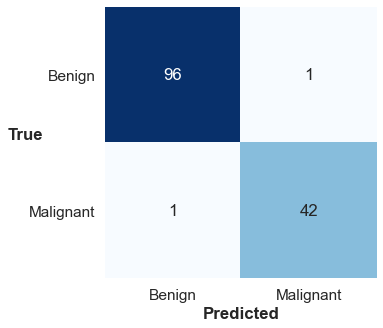

In [43]:
#print confusion matrix for logistic regression
sns.set(font_scale=1.4)
plt.figure(figsize=(10, 5))
sns.heatmap(logit_confusion,
            cmap=plt.cm.Blues,
            cbar=False,
            annot=True,
            square=True,
            fmt='d',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted', weight='bold')
plt.ylabel('True', rotation=0, weight='bold')
plt.yticks(rotation=0)
#plt.savefig('confusion_matrix.png', dpi=600)

In [44]:
#scaled coef of features (X2) in log odds
logit.coef_

array([[1.53240459, 0.70611871, 0.7739667 , 0.29564046, 1.70957923,
        0.92813299, 0.72266259, 0.95312796]])

In [45]:
# unscaled coef of features?
# unscaled_coef = np.true_divide(logit.coef_, scaler.scale_)
# unscaled_coef

In [46]:
#getting rid of log: this is the increase in likelihood of positive class (malignant tumor) for unit std deviation increase in feature
np.exp(logit.coef_)

array([[4.62929499, 2.02611204, 2.16835042, 1.34398686, 5.52663556,
        2.52978164, 2.0599106 , 2.59381031]])

## Exporting Data for Visualization

In [47]:
#exporting feature coefficients
columns = [
    'Clump Thickness', 'Uniform Cellsize', 'Marginal Adhesion',
    'Epithelial Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli',
    'Mitoses'
]
perc_inc= [
    362.929499, 102.611204, 116.835042, 34.398686, 452.663556,
        152.978164, 105.99106 , 159.381031
]
coef_dic = {'Characteristic': columns, 'Coefficient': perc_inc}

coefs_df = pd.DataFrame(coef_dic)
#coefs_df.to_csv('breastcancer_coefs.csv')

In [48]:
from src.models.logit_test import logit_test

logit_accuracy, logit_precision, logit_recall, logit_f1, logit_rocauc = logit_test(X2_train, X2_test, y2_train, y2_test)

In [49]:
#exporting logistic regression metrics
metrics = [
    'Accuracy', 'Precision', 'Recall', 'F1', 'ROC/AUC'
]
values = [
    logit_accuracy, logit_precision, logit_recall, logit_f1, logit_rocauc
]
metric_dic = {'Metric': metrics, 'Score': values}

metric_df = pd.DataFrame(metric_dic)
#metric_df.to_csv('breastcancer_logit_metrics.csv')